# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_100  O43405                              18.316
Sample_138  P00738                              19.534
Sample_041  E9PF59;P42658;P42658-2              15.690
Sample_153  A0A1W2PP80;C9JGI3;P19971;P19971-2   19.228
Sample_021  P06733                              16.441
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                            
Sample_015  Q86TY3;Q86TY3-2                              14.959
Sample_173  P01833                                       11.776
Sample_005  A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3   12.857
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.098
            A0A075B6Q5                 12.339
            A0A075B6R2                 12.502
            A0A075B6S5                 13.156
            A0A087WSY4                 13.672
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.977
            Q9UI40;Q9UI40-2            12.886
            Q9UIW2                     11.836
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.163
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.963,15.050,16.842,19.863,13.971,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.924,19.067,...,15.528,15.576,11.221,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.046,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,12.300,17.705,17.039,13.616,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.907,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.188,15.345,17.084,18.708,14.249,19.433,9.850,9.875
Sample_207,15.739,16.877,15.469,16.898,14.218,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.965,13.437,12.673,12.048,13.743,13.163,12.394,13.207,12.803,13.224
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.763,19.067,16.127,...,13.453,13.660,11.628,12.020,13.260,11.343,14.244,12.015,12.129,13.717
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.386,12.583,12.147,14.089,13.090,14.741,12.102,13.188,12.598,13.183
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.607,13.305,12.806,12.749,12.962,13.630,13.517,11.392,13.642,11.961
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.570,13.366,13.328,12.676,13.151,12.790,12.791,13.454,13.028,12.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.306,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 371.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.57it/s]

100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.16it/s]

100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.26it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.85it/s]

100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.49it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.07it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.54it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.80it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.35it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.79it/s]

100%|██████████| 7/7 [00:01<00:00,  3.38it/s]

100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.29it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.50it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.86it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.52it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.32it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.38it/s]

100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.12it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.49it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.21it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.10it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.98it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.99it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.77it/s]

100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

100%|██████████| 9/9 [00:02<00:00,  4.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.72it/s]

 30%|███       | 3/10 [00:00<00:01,  5.92it/s]

 40%|████      | 4/10 [00:00<00:01,  5.07it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.59it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.21it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.02it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.91it/s]

100%|██████████| 10/10 [00:02<00:00,  3.20it/s]

100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.00it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.21it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.72it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.64it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.13it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.22it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.38it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.21it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.95it/s]

100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.23it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.66it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.28it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.90it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.83it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.80it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.52it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.47it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.29it/s]

100%|██████████| 12/12 [00:02<00:00,  3.92it/s]

100%|██████████| 12/12 [00:02<00:00,  4.64it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.32it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.42it/s]

 31%|███       | 4/13 [00:00<00:01,  5.74it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.45it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.20it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.10it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.10it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.53it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.23it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.02it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.78it/s]

100%|██████████| 13/13 [00:03<00:00,  3.04it/s]

100%|██████████| 13/13 [00:03<00:00,  3.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.87it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.45it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.10it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.91it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.77it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.90it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.09it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.13it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.21it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.39it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.50it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.54it/s]

100%|██████████| 14/14 [00:04<00:00,  3.59it/s]

100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.99it/s]

 20%|██        | 3/15 [00:00<00:02,  4.07it/s]

 27%|██▋       | 4/15 [00:01<00:02,  3.71it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.60it/s]

 40%|████      | 6/15 [00:01<00:02,  3.64it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.71it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.65it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.64it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.44it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.39it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.63it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.66it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]

100%|██████████| 15/15 [00:03<00:00,  4.01it/s]

100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.053 0.023          0.638 0.420       0.085   
2             0.004 0.002      0.042 0.012          0.772 0.085       0.692   
3             0.004 0.002      0.046 0.016          0.771 0.085       0.698   
4             0.005 0.002      0.053 0.018          0.747 0.089       0.708   
5             0.003 0.000      0.036 0.001          0.762 0.080       0.696   
6             0.005 0.003      0.047 0.018          0.769 0.085       0.687   
7             0.005 0.002      0.053 0.020          0.781 0.089       0.719   
8             0.005 0.002      0.052 0.017          0.780 0.085       0.724   
9             0.005 0.002      0.049 0.016          0.781 0.090       0.776   
10            0.006 0.002      0.055 0.018          0.780 0.091       0.775   
11            0.006 0.004      0.062 0.025          0.789 0.086       0.784   
12            0.005 0.002      0.054 0.019          0.799 0.088       0.805   
13            0.005 0.002      0.045 0.016          0.798 0.076       0.804   
14            0.004 0.001      0.034 0.002          0.798 0.084       0.811   
15            0.004 0.001      0.040 0.011          0.796 0.085       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.143 0.124                  0.535 0.037        0.846   
2          0.110   0.722 0.074                  0.769 0.057        0.858   
3          0.101   0.727 0.068                  0.771 0.054        0.856   
4          0.094   0.722 0.066                  0.764 0.055        0.853   
5          0.096   0.723 0.068                  0.767 0.056        0.863   
6          0.103   0.719 0.069                  0.765 0.055        0.864   
7          0.115   0.742 0.077                  0.784 0.062        0.867   
8          0.106   0.746 0.075                  0.786 0.061        0.865   
9          0.103   0.773 0.072                  0.807 0.060        0.898   
10         0.104   0.773 0.075                  0.806 0.063        0.899   
11         0.104   0.782 0.071                  0.814 0.059        0.898   
12         0.099   0.798 0.073                  0.827 0.061        0.903   
13         0.098   0.798 0.070                  0.827 0.060        0.906   
14         0.098   0.801 0.071                  0.829 0.061        0.904   
15         0.099   0.798 0.071                  0.827 0.061        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.819 0.087        210.000 0.000  
2          0.058                  0.826 0.069        210.000 0.000  
3          0.058                  0.827 0.065        210.000 0.000  
4          0.055                  0.826 0.061        210.000 0.000  
5          0.056                  0.835 0.064        210.000 0.000  
6          0.056                  0.832 0.064        210.000 0.000  
7          0.055                  0.843 0.062        210.000 0.000  
8          0.055                  0.840 0.062        210.000 0.000  
9          0.050                  0.877 0.055        210.000 0.000  
10         0.051                  0.878 0.056        210.000 0.000  
11         0.052                  0.873 0.059        210.000 0.000  
12         0.052                  0.886 0.054        210.000 0.000  
13         0.052                  0.889 0.055        210.000 0.000  
14         0.054                  0.890 0.055        210.000 0.000  
15         0.053                  0.890 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 504.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.73it/s]

100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

100%|██████████| 4/4 [00:00<00:00,  3.88it/s]

100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.26it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.28it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.53it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.30it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.23it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.00it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.50it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.86it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.32it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.25it/s]

100%|██████████| 7/7 [00:01<00:00,  3.42it/s]

100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.83it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.49it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.06it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.28it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.42it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.07it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.03it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.75it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.72it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.71it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.71it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.44it/s]

100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.81it/s]

 30%|███       | 3/10 [00:00<00:01,  5.69it/s]

 40%|████      | 4/10 [00:00<00:01,  4.38it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.04it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.85it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.72it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.61it/s]

100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.60it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.88it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.18it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.84it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.75it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.62it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.73it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.81it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.89it/s]

100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

100%|██████████| 11/11 [00:02<00:00,  3.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.14it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.13it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.70it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.53it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.45it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.42it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.38it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.29it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.23it/s]

100%|██████████| 12/12 [00:04<00:00,  2.20it/s]

100%|██████████| 12/12 [00:04<00:00,  2.55it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.49it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.52it/s]

 31%|███       | 4/13 [00:00<00:02,  4.18it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.90it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.77it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.74it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.64it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.57it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.20it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.24it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.26it/s]

100%|██████████| 13/13 [00:03<00:00,  2.91it/s]

100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.10it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.97it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.62it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.70it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.88it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.72it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.81it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.95it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.05it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.24it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.38it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.40it/s]

100%|██████████| 14/14 [00:04<00:00,  3.44it/s]

100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.15it/s]

 20%|██        | 3/15 [00:00<00:02,  5.23it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.77it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.78it/s]

 40%|████      | 6/15 [00:01<00:02,  3.78it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.52it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.87it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.65it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.40it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.47it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.70it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.94it/s]

100%|██████████| 15/15 [00:04<00:00,  2.99it/s]

100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.038 0.011          0.681 0.404       0.095   
2             0.005 0.002      0.055 0.019          0.685 0.125       0.536   
3             0.004 0.001      0.041 0.012          0.703 0.110       0.620   
4             0.004 0.002      0.043 0.017          0.734 0.101       0.640   
5             0.004 0.002      0.039 0.016          0.714 0.105       0.640   
6             0.004 0.002      0.040 0.012          0.808 0.086       0.764   
7             0.004 0.001      0.039 0.010          0.817 0.087       0.765   
8             0.004 0.001      0.042 0.014          0.842 0.073       0.800   
9             0.004 0.001      0.037 0.008          0.830 0.071       0.808   
10            0.004 0.001      0.039 0.010          0.823 0.072       0.814   
11            0.004 0.001      0.039 0.012          0.816 0.075       0.807   
12            0.004 0.001      0.042 0.013          0.812 0.073       0.800   
13            0.005 0.002      0.051 0.018          0.825 0.071       0.808   
14            0.006 0.004      0.055 0.025          0.824 0.075       0.807   
15            0.004 0.001      0.040 0.012          0.813 0.079       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.161 0.123                  0.540 0.038        0.846   
2          0.107   0.594 0.088                  0.674 0.064        0.726   
3          0.129   0.649 0.091                  0.709 0.070        0.783   
4          0.104   0.677 0.076                  0.732 0.059        0.813   
5          0.111   0.667 0.082                  0.722 0.064        0.804   
6          0.104   0.780 0.073                  0.814 0.060        0.888   
7          0.110   0.785 0.075                  0.818 0.060        0.890   
8          0.102   0.816 0.064                  0.844 0.053        0.905   
9          0.100   0.815 0.064                  0.843 0.053        0.899   
10         0.097   0.814 0.062                  0.842 0.051        0.898   
11         0.098   0.807 0.060                  0.836 0.050        0.898   
12         0.086   0.802 0.056                  0.831 0.046        0.898   
13         0.094   0.812 0.059                  0.840 0.049        0.904   
14         0.098   0.811 0.063                  0.839 0.053        0.904   
15         0.097   0.814 0.066                  0.841 0.057        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.823 0.088        210.000 0.000  
2          0.082                  0.694 0.099        210.000 0.000  
3          0.075                  0.718 0.094        210.000 0.000  
4          0.067                  0.781 0.089        210.000 0.000  
5          0.066                  0.767 0.090        210.000 0.000  
6          0.054                  0.859 0.065        210.000 0.000  
7          0.053                  0.865 0.059        210.000 0.000  
8          0.048                  0.881 0.063        210.000 0.000  
9          0.048                  0.877 0.063        210.000 0.000  
10         0.047                  0.875 0.058        210.000 0.000  
11         0.048                  0.875 0.057        210.000 0.000  
12         0.048                  0.879 0.057        210.000 0.000  
13         0.048                  0.887 0.054        210.000 0.000  
14         0.049                  0.889 0.054        210.000 0.000  
15         0.051                  0.895 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1083.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.54it/s]

100%|██████████| 3/3 [00:00<00:00, 13.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.65it/s]

100%|██████████| 4/4 [00:00<00:00, 14.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 14.53it/s]

 80%|████████  | 4/5 [00:00<00:00, 10.77it/s]

100%|██████████| 5/5 [00:00<00:00, 10.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 27.21it/s]

100%|██████████| 6/6 [00:00<00:00, 19.87it/s]

100%|██████████| 6/6 [00:00<00:00, 20.63it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.92it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.96it/s]

100%|██████████| 7/7 [00:00<00:00, 18.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 30.73it/s]

100%|██████████| 8/8 [00:00<00:00, 28.59it/s]

100%|██████████| 8/8 [00:00<00:00, 28.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 24.88it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 19.27it/s]

100%|██████████| 9/9 [00:00<00:00, 17.94it/s]

100%|██████████| 9/9 [00:00<00:00, 18.65it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 28.05it/s]

 60%|██████    | 6/10 [00:00<00:00, 22.41it/s]

 90%|█████████ | 9/10 [00:00<00:00, 21.49it/s]

100%|██████████| 10/10 [00:00<00:00, 21.94it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 27.11it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 22.46it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 20.69it/s]

100%|██████████| 11/11 [00:00<00:00, 20.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 35.52it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 21.52it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 17.32it/s]

100%|██████████| 12/12 [00:00<00:00, 18.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 29.20it/s]

 46%|████▌     | 6/13 [00:00<00:00, 21.80it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 20.14it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 22.70it/s]

100%|██████████| 13/13 [00:00<00:00, 22.98it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.34it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.49it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.24it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.73it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 18.13it/s]

100%|██████████| 14/14 [00:00<00:00, 17.43it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 35.65it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 30.43it/s]

 80%|████████  | 12/15 [00:00<00:00, 28.71it/s]

100%|██████████| 15/15 [00:00<00:00, 28.02it/s]

100%|██████████| 15/15 [00:00<00:00, 28.91it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.048 0.018          0.308 0.430       0.027   
2             0.005 0.002      0.052 0.019          0.541 0.101       0.307   
3             0.005 0.002      0.052 0.021          0.537 0.084       0.357   
4             0.005 0.002      0.047 0.017          0.552 0.087       0.368   
5             0.005 0.003      0.049 0.018          0.565 0.092       0.388   
6             0.004 0.002      0.040 0.016          0.545 0.087       0.390   
7             0.003 0.001      0.031 0.013          0.551 0.082       0.409   
8             0.003 0.002      0.035 0.019          0.575 0.102       0.439   
9             0.003 0.001      0.027 0.009          0.570 0.103       0.439   
10            0.004 0.002      0.040 0.019          0.557 0.103       0.438   
11            0.002 0.000      0.022 0.004          0.545 0.093       0.422   
12            0.004 0.001      0.034 0.013          0.537 0.090       0.421   
13            0.002 0.001      0.023 0.008          0.534 0.094       0.421   
14            0.004 0.001      0.032 0.007          0.547 0.105       0.457   
15            0.003 0.002      0.032 0.017          0.541 0.105       0.458   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.049 0.069                  0.507 0.022        0.748   
2          0.109   0.383 0.105                  0.559 0.050        0.665   
3          0.098   0.422 0.086                  0.566 0.047        0.670   
4          0.091   0.435 0.079                  0.573 0.049        0.666   
5          0.090   0.453 0.079                  0.582 0.052        0.659   
6          0.095   0.448 0.078                  0.574 0.050        0.648   
7          0.088   0.465 0.075                  0.582 0.053        0.646   
8          0.095   0.492 0.083                  0.597 0.064        0.656   
9          0.096   0.490 0.084                  0.594 0.067        0.651   
10         0.103   0.483 0.085                  0.587 0.067        0.642   
11         0.097   0.469 0.079                  0.578 0.062        0.634   
12         0.092   0.466 0.075                  0.574 0.060        0.628   
13         0.096   0.464 0.079                  0.572 0.064        0.617   
14         0.103   0.491 0.086                  0.586 0.067        0.628   
15         0.102   0.490 0.088                  0.583 0.070        0.617   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.657 0.078        210.000 0.000  
2          0.069                  0.600 0.070        210.000 0.000  
3          0.064                  0.618 0.069        210.000 0.000  
4          0.065                  0.613 0.068        210.000 0.000  
5          0.061                  0.608 0.065        210.000 0.000  
6          0.060                  0.593 0.064        210.000 0.000  
7          0.066                  0.612 0.071        210.000 0.000  
8          0.074                  0.645 0.073        210.000 0.000  
9          0.074                  0.637 0.071        210.000 0.000  
10         0.074                  0.630 0.073        210.000 0.000  
11         0.073                  0.621 0.070        210.000 0.000  
12         0.073                  0.617 0.071        210.000 0.000  
13         0.075                  0.607 0.073        210.000 0.000  
14         0.077                  0.608 0.074        210.000 0.000  
15         0.077                  0.596 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,14,5
score_time,11,14,2
test_precision,12,8,8
test_recall,14,15,15
test_f1,14,8,8
test_balanced_accuracy,14,8,8
test_roc_auc,13,8,1
test_average_precision,14,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.07it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.39it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.63it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  5.30it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  5.58it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.77it/s]

100%|██████████| 8/8 [00:01<00:00,  5.81it/s]

100%|██████████| 8/8 [00:01<00:00,  5.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1479.47it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 13.75it/s]

 31%|███       | 4/13 [00:00<00:01,  7.51it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.00it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.02it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.66it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.00it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.65it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  5.11it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  5.54it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  5.88it/s]

100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

100%|██████████| 13/13 [00:02<00:00,  5.26it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


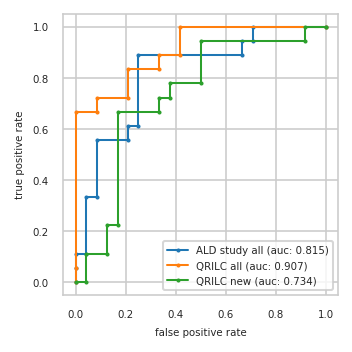

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.111     0.000 0.667     0.042 0.111
3          0.042 0.111     0.083 0.667     0.125 0.111
4          0.042 0.333     0.083 0.722     0.125 0.222
5          0.083 0.333     0.208 0.722     0.167 0.222
6          0.083 0.556     0.208 0.833     0.167 0.667
7          0.208 0.556     0.333 0.833     0.333 0.667
8          0.208 0.611     0.333 0.889     0.333 0.722
9          0.250 0.611     0.417 0.889     0.375 0.722
10         0.250 0.889     0.417 1.000     0.375 0.778
11         0.667 0.889     1.000 1.000     0.500 0.778
12         0.667 0.944       NaN   NaN     0.500 0.944
13         0.708 0.944       NaN   NaN     0.917 0.944
14         0.708 1.000       NaN   NaN     0.917 1.000
15         1.000 1.000       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,Q9NX62,P60709;P63261,None
2,P04114,P10636-2;P10636-6,None
3,P61981,A0A0A0MRJ7;P12259,None
4,P14174,P14174,None
5,P04075,P61981,None
6,Q9Y2T3;Q9Y2T3-3,P04075,None
7,P63104,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3,None
8,C9JF17;P05090,None,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


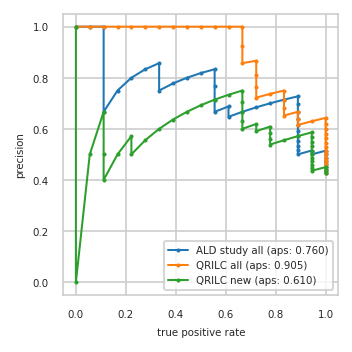

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.500 0.889     0.562 1.000     0.531 0.944
11         0.516 0.889     0.581 1.000     0.548 0.944
12         0.533 0.889     0.600 1.000     0.567 0.944
13         0.552 0.889     0.621 1.000     0.586 0.944
14         0.571 0.889     0.643 1.000     0.571 0.889
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.684 0.722     0.737 0.778     0.632 0.667
24         0.667 0.667     0.722 0.722     0.667 0.667
25         0.647 0.611     0.765 0.722     0.706 0.667
26         0.688 0.611     0.812 0.722     0.750 0.667
27         0.667 0.556     0.867 0.722     0.733 0.611
28         0.714 0.556     0.857 0.667     0.714 0.556
29         0.769 0.556     0.923 0.667     0.692 0.500
30         0.833 0.556     1.000 0.667     0.667 0.444
31         0.818 0.500     1.000 0.611     0.636 0.389
32         0.800 0.444     1.000 0.556     0.600 0.333
33         0.778 0.389     1.000 0.500     0.556 0.278
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


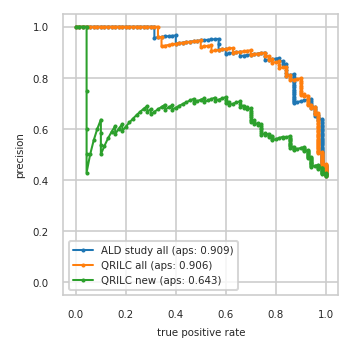

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


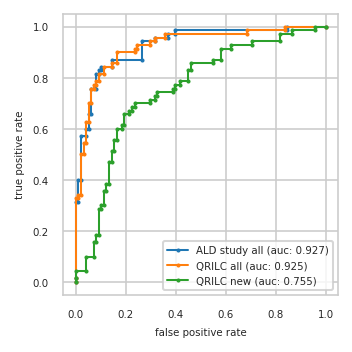

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}